In [7]:
# Demange Aymeric 02/10/2020
# Projet sur un dataset d'anime


import seaborn as sns
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split as TTS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN #KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
mm_scaler = preprocessing.MinMaxScaler()
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
from pandas_profiling import ProfileReport



warnings.filterwarnings("ignore")

sns.set

# charger le dataset
dataAnime = pd.read_csv(r"/content/dataanime.csv")
df_dataAnime = dataAnime.copy()

In [8]:
#A activer si l'on souhaite installer profiling pandas
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [9]:
# Cette fonction permet de convertir les tirets en "Unknown" en leur passant en argument la colonne en question

def dashToUnknown(value) :
    if (value == '-' ) :
      return 'Unknown'
    else : 
      return value

def fillEndingDate(row) :
  if ( (row.Type == 3 or row.Type == 0) and row.EndingDate == '-') :
    row.EndingDate = row.StartingDate
  return row

def getBroadcastDay(value) :
    splitted = value.split()
    return splitted[0]

def getBroadcastTime(value) :
    splitted = value.split()
    if (len(splitted)== 4) :
      return splitted[2]
    else :
      return 'Unknown'

def getSplittedByComa(value) :
    splitted = value.split(",")
    return splitted

def getSplittedByBlankSpace(value) :
    splitted = value.split()
    return splitted

def copyDf(df,dfToCopy) :
  for col in dfToCopy.columns:
      df[col] = dfToCopy[col]

def getTimePerTitle(value) :
  splitted = value.replace("-","0")
  splitted = splitted.replace("per ep.","").split()
  if (len(splitted) == 4) :
    return (int(splitted[0])*60 + int(splitted[2]))
  elif (len(splitted) == 2) :
    return (int(splitted[0]) * int(df_dataAnime.Episodes.iloc[0]))
  else :
    return (splitted[0])

# Petite fonction permettant de calculer l'accuracy et ensuite de le mettre en %
def accuracy(preds, Y):
  print(preds.shape, Y.shape)
  return ((preds == Y).sum() / len(Y) * 100)

def learning_curves(estimator, data, features, target, train_sizes, cv):
   train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =
    train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
   train_scores_mean = -train_scores.mean(axis = 1)
   validation_scores_mean = -validation_scores.mean(axis = 1)

   plt.plot(train_sizes, train_scores_mean, label = 'Training error')
   plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

   plt.ylabel('MSE', fontsize = 14)
   plt.xlabel('Training set size', fontsize = 14)
   title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
   plt.title(title, fontsize = 18, y = 1.03)
   plt.legend()
   plt.ylim(0,40)
   
def show_roc(model,X_test,Y_test) :
  metrics.plot_roc_curve(model, X_test, Y_test)
  plt.show()



---


# **Voici notre dataframe d'origine**

---



In [10]:
df_dataAnime

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Score,Scored by,Members,Favorites,Description
0,Fullmetal Alchemist: Brotherhood,TV,64,Finished Airing,2009-4-5,2010-7-4,Spring,Sundays at 17:00 (JST),"Aniplex,Square Enix,Mainichi Broadcasting Syst...","Funimation,Aniplex of America",Bones,Manga,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,R,9.25,719706,1176368,105387,"""In order for something to be obtained, someth..."
1,Kimi no Na wa.,Movie,1,Finished Airing,2016-8-26,-,-,-,"Kadokawa Shoten,Toho,Sound Team Don Juan,Lawso...","Funimation,NYAV Post",CoMix Wave Films,Original,"Supernatural,Drama,Romance,School",1 hr. 46 min.,PG-13,9.19,454969,705186,33936,"Mitsuha Miyamizu, a high school girl, yearns t..."
2,Gintama°,TV,51,Finished Airing,2015-4-8,2016-3-30,Spring,Wednesdays at 18:00 (JST),"TV Tokyo,Aniplex,Dentsu","Funimation,Crunchyroll",Bandai Namco Pictures,Manga,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,R,9.16,70279,194359,5597,"Gintoki, Shinpachi, and Kagura return as the f..."
3,Steins;Gate 0,TV,23,Currently Airing,2018-4-12,-,Spring,Thursdays at 01:35 (JST),Nitroplus,Funimation,White Fox,Visual novel,"Sci-Fi,Thriller",23 min. per ep.,PG-13,9.16,12609,186331,1117,The dark untold story of Steins;Gate that lead...
4,Steins;Gate,TV,24,Finished Airing,2011-4-6,2011-9-14,Spring,Wednesdays at 02:05 (JST),"Frontier Works,Media Factory,Movic,AT-X,Kadoka...",Funimation,White Fox,Visual novel,"Sci-Fi,Thriller",24 min. per ep.,PG-13,9.14,552791,990419,90365,The self-proclaimed mad scientist Rintarou Oka...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,TV,12,Finished Airing,2010-7-2,2010-9-17,Summer,-,"Aniplex,Square Enix,Mainichi Broadcasting System",Funimation,A-1 Pictures,Manga,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,R,7.48,171506,296985,3576,The stage of Kuroshitsuji II opens on the life...
1559,Minami-ke Natsuyasumi,OVA,1,Finished Airing,2013-8-6,-,-,-,Starchild Records,-,feel.,Manga,"Comedy,Slice of Life",28 min.,PG-13,7.48,6062,12111,4,Second Minami-ke OVA bundled with the 11th vol...
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,Movie,1,Finished Airing,2009-8-1,-,-,-,Toho,Viz Media,Studio Pierrot,Manga,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,PG-13,7.48,61505,104288,129,Ninjas with bloodline limits begin disappearin...
1561,Persona 4 the Animation: The Factor of Hope,Movie,1,Finished Airing,2012-6-9,-,-,-,Index,-,AIC A.S.T.A.,-,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,PG-13,7.48,3054,12868,12,Recap of the entire 25-episode television anim...


# **Phase de Data Cleaning**


**On drop les NaN afin  clean notre dataframe**



In [11]:
# Je décide de drop tous les na dans les datasets afin de supprimer d'éventuels lignes érronées 
df_dataAnime = df_dataAnime.copy()
df_dataAnime = df_dataAnime.dropna()

**On renomme le nom de nos colonnes car il y a des espaces dedans**

In [12]:
df_dataAnime.rename(columns={'Start airing': 'StartingDate', 'End airing': 'EndingDate', 'Starting season':'StartingSeason', 'Broadcast time':'BroadcastTime','Scored by':'ScoredBy'}, inplace=True)
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,Description
0,Fullmetal Alchemist: Brotherhood,TV,64,Finished Airing,2009-4-5,2010-7-4,Spring,Sundays at 17:00 (JST),"Aniplex,Square Enix,Mainichi Broadcasting Syst...","Funimation,Aniplex of America",Bones,Manga,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,R,9.25,719706,1176368,105387,"""In order for something to be obtained, someth..."
1,Kimi no Na wa.,Movie,1,Finished Airing,2016-8-26,-,-,-,"Kadokawa Shoten,Toho,Sound Team Don Juan,Lawso...","Funimation,NYAV Post",CoMix Wave Films,Original,"Supernatural,Drama,Romance,School",1 hr. 46 min.,PG-13,9.19,454969,705186,33936,"Mitsuha Miyamizu, a high school girl, yearns t..."
2,Gintama°,TV,51,Finished Airing,2015-4-8,2016-3-30,Spring,Wednesdays at 18:00 (JST),"TV Tokyo,Aniplex,Dentsu","Funimation,Crunchyroll",Bandai Namco Pictures,Manga,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,R,9.16,70279,194359,5597,"Gintoki, Shinpachi, and Kagura return as the f..."
3,Steins;Gate 0,TV,23,Currently Airing,2018-4-12,-,Spring,Thursdays at 01:35 (JST),Nitroplus,Funimation,White Fox,Visual novel,"Sci-Fi,Thriller",23 min. per ep.,PG-13,9.16,12609,186331,1117,The dark untold story of Steins;Gate that lead...
4,Steins;Gate,TV,24,Finished Airing,2011-4-6,2011-9-14,Spring,Wednesdays at 02:05 (JST),"Frontier Works,Media Factory,Movic,AT-X,Kadoka...",Funimation,White Fox,Visual novel,"Sci-Fi,Thriller",24 min. per ep.,PG-13,9.14,552791,990419,90365,The self-proclaimed mad scientist Rintarou Oka...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,TV,12,Finished Airing,2010-7-2,2010-9-17,Summer,-,"Aniplex,Square Enix,Mainichi Broadcasting System",Funimation,A-1 Pictures,Manga,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,R,7.48,171506,296985,3576,The stage of Kuroshitsuji II opens on the life...
1559,Minami-ke Natsuyasumi,OVA,1,Finished Airing,2013-8-6,-,-,-,Starchild Records,-,feel.,Manga,"Comedy,Slice of Life",28 min.,PG-13,7.48,6062,12111,4,Second Minami-ke OVA bundled with the 11th vol...
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,Movie,1,Finished Airing,2009-8-1,-,-,-,Toho,Viz Media,Studio Pierrot,Manga,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,PG-13,7.48,61505,104288,129,Ninjas with bloodline limits begin disappearin...
1561,Persona 4 the Animation: The Factor of Hope,Movie,1,Finished Airing,2012-6-9,-,-,-,Index,-,AIC A.S.T.A.,-,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,PG-13,7.48,3054,12868,12,Recap of the entire 25-episode television anim...


**Ici on vas transformer nos lignes / Colonnes qui peuvent être directement faites**

In [13]:
# Je vais ensuite transformer mes colonnes qualitative en donnée quantitative via la méthode : "labelencoder"
# Cette méthode permet de trouver toutes les différentes valeur présentes dans une colonne et d'associer une valeur numérique à la place. 
# Si deux valeurs sont identiques elles prennent le même nombre

df_dataAnime['Rating'] = labelencoder.fit_transform(df_dataAnime['Rating'])
df_dataAnime['Type'] = labelencoder.fit_transform(df_dataAnime['Type'])
df_dataAnime['Status'] = labelencoder.fit_transform(df_dataAnime['Status'])
df_dataAnime['Sources'] = labelencoder.fit_transform(df_dataAnime['Sources'])


# Exemple de comment transformer la colonne "Sources" qui possède des valeurs qui peuvent être transformé en booléen. J'utilise la méthode cat.codes

#df_dataAnime.Sources = df_dataAnime['Sources'].astype('category').cat.codes

# Je décide de supprimer la colonne description, il faudrait créer une recherche afin de déterminer des mots clés importants.

df_dataAnime = df_dataAnime.drop(['Description', 'Producers'], axis= 1)

df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites
0,Fullmetal Alchemist: Brotherhood,5,64,1,2009-4-5,2010-7-4,Spring,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387
1,Kimi no Na wa.,0,1,1,2016-8-26,-,-,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936
2,Gintama°,5,51,1,2015-4-8,2016-3-30,Spring,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597
3,Steins;Gate 0,5,23,0,2018-4-12,-,Spring,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117
4,Steins;Gate,5,24,1,2011-4-6,2011-9-14,Spring,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2010-7-2,2010-9-17,Summer,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576
1559,Minami-ke Natsuyasumi,3,1,1,2013-8-6,-,-,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,2009-8-1,-,-,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,2012-6-9,-,-,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12


**Fonction dash to unknown**

In [14]:
# On fait appel à la fonction dash to unknown qui transforme dans une colonne donnée tous les tirets
df_dataAnime.StartingSeason = df_dataAnime.StartingSeason.apply(dashToUnknown)
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites
0,Fullmetal Alchemist: Brotherhood,5,64,1,2009-4-5,2010-7-4,Spring,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387
1,Kimi no Na wa.,0,1,1,2016-8-26,-,Unknown,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936
2,Gintama°,5,51,1,2015-4-8,2016-3-30,Spring,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597
3,Steins;Gate 0,5,23,0,2018-4-12,-,Spring,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117
4,Steins;Gate,5,24,1,2011-4-6,2011-9-14,Spring,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2010-7-2,2010-9-17,Summer,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576
1559,Minami-ke Natsuyasumi,3,1,1,2013-8-6,-,Unknown,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,2009-8-1,-,Unknown,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,2012-6-9,-,Unknown,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12


**Maintenant que la colonne StartingSeason ne possède que des valeurs que l'on peut transformer j'utilise la méthode astype**

In [15]:
# Transformation en valeur quantitative
df_dataAnime.StartingSeason = df_dataAnime['StartingSeason'].astype('category').cat.codes
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites
0,Fullmetal Alchemist: Brotherhood,5,64,1,2009-4-5,2010-7-4,1,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387
1,Kimi no Na wa.,0,1,1,2016-8-26,-,3,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936
2,Gintama°,5,51,1,2015-4-8,2016-3-30,1,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597
3,Steins;Gate 0,5,23,0,2018-4-12,-,1,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117
4,Steins;Gate,5,24,1,2011-4-6,2011-9-14,1,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2010-7-2,2010-9-17,2,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576
1559,Minami-ke Natsuyasumi,3,1,1,2013-8-6,-,3,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,2009-8-1,-,3,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,2012-6-9,-,3,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12


**Afin de pouvoir utiliser la date je souhaite connaitre son type pour pouvoir la  transformer**

In [16]:
# Pour gérer mes dates je veux savoir leur format de base, c'est donc des objets, il faut les passer en dateTime pour utiliser pandas avec
df_dataAnime.StartingDate.head(5)

0     2009-4-5
1    2016-8-26
2     2015-4-8
3    2018-4-12
4     2011-4-6
Name: StartingDate, dtype: object

**J'ai décidé de faire du feature engineering, j'ai remarqué que les types étant des films ne possédait pas de date de fin alors qu'une fois un film sortie il est fini, j'ai donc ajouté aux types "Film" et "OAV" la date de fin = Date de Sortie**

In [17]:
# Utilisation de la fonction fillEndingDate
df_dataAnime = df_dataAnime.apply(fillEndingDate, axis=1)
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites
0,Fullmetal Alchemist: Brotherhood,5,64,1,2009-4-5,2010-7-4,1,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387
1,Kimi no Na wa.,0,1,1,2016-8-26,2016-8-26,3,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936
2,Gintama°,5,51,1,2015-4-8,2016-3-30,1,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597
3,Steins;Gate 0,5,23,0,2018-4-12,-,1,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117
4,Steins;Gate,5,24,1,2011-4-6,2011-9-14,1,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2010-7-2,2010-9-17,2,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576
1559,Minami-ke Natsuyasumi,3,1,1,2013-8-6,2013-8-6,3,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,2009-8-1,2009-8-1,3,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,2012-6-9,2012-6-9,3,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12


**Modification du type des dates**

In [18]:
# Je transforme mes dates via la méthode "to_datetime". Je gère les erreurs via l'argument 'coerce' qui lorsqu'il voit quelque chose ne possédant pas le format choisi assigne la valeur NaT

df_dataAnime.StartingDate = pd.to_datetime(df_dataAnime.StartingDate, 
 format = '%Y-%m-%dT',
 errors = 'coerce')

df_dataAnime.EndingDate = pd.to_datetime(df_dataAnime.EndingDate, 
 format = '%Y-%m-%dT',
 errors = 'coerce')

df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites
0,Fullmetal Alchemist: Brotherhood,5,64,1,2009-04-05,2010-07-04,1,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387
1,Kimi no Na wa.,0,1,1,2016-08-26,2016-08-26,3,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936
2,Gintama°,5,51,1,2015-04-08,2016-03-30,1,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597
3,Steins;Gate 0,5,23,0,2018-04-12,NaT,1,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117
4,Steins;Gate,5,24,1,2011-04-06,2011-09-14,1,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2010-07-02,2010-09-17,2,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576
1559,Minami-ke Natsuyasumi,3,1,1,2013-08-06,2013-08-06,3,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,2009-08-01,2009-08-01,3,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,2012-06-09,2012-06-09,3,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12


In [19]:
# Maintenant que mes dates sont bien au format DateTime je peut via pandas séparer les dates.
# Je crée des colonnes pour chaque partie de mes dates

df_dataAnime['StartingDate_year'] = df_dataAnime.StartingDate.dt.year
df_dataAnime['StartingDate_month'] = df_dataAnime.StartingDate.dt.month
df_dataAnime['StartingDate_day'] = df_dataAnime.StartingDate.dt.day

df_dataAnime['EndingDate_year'] = df_dataAnime.EndingDate.dt.year
df_dataAnime['EndingDate_month'] = df_dataAnime.EndingDate.dt.month
df_dataAnime['EndingDate_day'] = df_dataAnime.EndingDate.dt.day

# Je drop StartingDate et EndingDate car j'ai fractionné mes dates, je n'en ai plus besoin dans ce format et type

df_dataAnime = df_dataAnime.drop(['StartingDate','EndingDate'], axis= 1)

df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0
1,Kimi no Na wa.,0,1,1,3,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0
2,Gintama°,5,51,1,1,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0
3,Steins;Gate 0,5,23,0,1,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN
4,Steins;Gate,5,24,1,1,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0
1559,Minami-ke Natsuyasumi,3,1,1,3,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0


In [20]:
# Utilisation de la fonction dashToUnknown
df_dataAnime.BroadcastTime = df_dataAnime.BroadcastTime.apply(dashToUnknown)
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0
1,Kimi no Na wa.,0,1,1,3,Unknown,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0
2,Gintama°,5,51,1,1,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0
3,Steins;Gate 0,5,23,0,1,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN
4,Steins;Gate,5,24,1,1,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,Unknown,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0
1559,Minami-ke Natsuyasumi,3,1,1,3,Unknown,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,Unknown,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,Unknown,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0


**On continue de transformer nos colonnes** </br>
**Sur la colonne BroadCastTime on souhaite récupérer le jour et l'heure de sortie des épisodes**

In [21]:
# On utilise la fonction getBroadcast... qui fait un split sur les espaces pour pouvoir ensuite utilisé seulement ce qui nous intéresse
df_dataAnime['BroadcastDay'] = df_dataAnime.BroadcastTime.apply(getBroadcastDay)
df_dataAnime['BroadcastTime'] = df_dataAnime.BroadcastTime.apply(getBroadcastTime)

# On transforme les valeurs qualitatives en quantitatives
df_dataAnime['BroadcastDay'] = labelencoder.fit_transform(df_dataAnime['BroadcastDay'])
df_dataAnime['BroadcastTime'] = labelencoder.fit_transform(df_dataAnime['BroadcastTime'])
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,59,"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4
1,Kimi no Na wa.,0,1,1,3,81,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7
2,Gintama°,5,51,1,1,63,"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8
3,Steins;Gate 0,5,23,0,1,19,Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN,5
4,Steins;Gate,5,24,1,1,26,Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,81,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7
1559,Minami-ke Natsuyasumi,3,1,1,3,81,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,81,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,81,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7


In [22]:
# On appelle la fonction getSplittedByBlankSpace afin de pouvoir creer une liste en fonction d'une séparation par un espace.
# Une fois une liste crée on vas encoder chaque ligne et chaque objet via labelEncoder

df_dataAnime.Studios = df_dataAnime.Studios.apply(getSplittedByBlankSpace)
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,59,"Funimation,Aniplex of America",[Bones],6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4
1,Kimi no Na wa.,0,1,1,3,81,"Funimation,NYAV Post","[CoMix, Wave, Films]",9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7
2,Gintama°,5,51,1,1,63,"Funimation,Crunchyroll","[Bandai, Namco, Pictures]",6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8
3,Steins;Gate 0,5,23,0,1,19,Funimation,"[White, Fox]",12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN,5
4,Steins;Gate,5,24,1,1,26,Funimation,"[White, Fox]",12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,81,Funimation,"[A-1, Pictures]",6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7
1559,Minami-ke Natsuyasumi,3,1,1,3,81,-,[feel.],6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,81,Viz Media,"[Studio, Pierrot]",6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,81,-,"[AIC, A.S.T.A.]",0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7


In [23]:
# On appelle la fonction getSplittedByComa afin de pouvoir creer une liste en fonction d'une séparation par une virgule.
# Une fois une liste crée on vas encoder chaque ligne et chaque objet via labelEncoder

#df_dataAnime.Producers = df_dataAnime.Producers.apply(getSplittedByComa)
#df_dataAnime.Licensors = df_dataAnime.Licensors.apply(getSplittedByComa)
df_dataAnime.Genres = df_dataAnime.Genres.apply(getSplittedByComa)
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,59,"Funimation,Aniplex of America",[Bones],6,"[Action, Military, Adventure, Comedy, Drama, M...",24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4
1,Kimi no Na wa.,0,1,1,3,81,"Funimation,NYAV Post","[CoMix, Wave, Films]",9,"[Supernatural, Drama, Romance, School]",1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7
2,Gintama°,5,51,1,1,63,"Funimation,Crunchyroll","[Bandai, Namco, Pictures]",6,"[Action, Comedy, Historical, Parody, Samurai, ...",24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8
3,Steins;Gate 0,5,23,0,1,19,Funimation,"[White, Fox]",12,"[Sci-Fi, Thriller]",23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN,5
4,Steins;Gate,5,24,1,1,26,Funimation,"[White, Fox]",12,"[Sci-Fi, Thriller]",24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,81,Funimation,"[A-1, Pictures]",6,"[Action, Comedy, Demons, Supernatural, Fantasy...",24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7
1559,Minami-ke Natsuyasumi,3,1,1,3,81,-,[feel.],6,"[Comedy, Slice of Life]",28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,81,Viz Media,"[Studio, Pierrot]",6,"[Action, Comedy, Martial Arts, Shounen, Super ...",1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,81,-,"[AIC, A.S.T.A.]",0,"[Adventure, Mystery, Super Power, Supernatural...",1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7


In [24]:
# Cette cellule me permettait d'éclater mes listes afin d'obtenir des colonnes comportant le nom de chacun des éléments présent dans la colonne ciblé


#newdf_dataAnime = df_dataAnime.Genres.apply(frozenset).to_frame(name='Genres')

#for Genres in frozenset.union(*newdf_dataAnime.Genres):
 #   newdf_dataAnime[Genres] = newdf_dataAnime.apply(lambda x: int(Genres in x.Genres), axis=1)

#copyDf(df_dataAnime, newdf_dataAnime)

#newdf_dataAnime = df_dataAnime.Licensors.apply(frozenset).to_frame(name='Licensors')

#for Licensors in frozenset.union(*newdf_dataAnime.Licensors):
 # newdf_dataAnime[Licensors] = newdf_dataAnime.apply(lambda x: int(Licensors in x.Licensors), axis=1)

#copyDf(df_dataAnime, newdf_dataAnime)

#newdf_dataAnime = df_dataAnime.Studios.apply(frozenset).to_frame(name='Studios')

#for Studios in frozenset.union(*newdf_dataAnime.Studios):
 # newdf_dataAnime[Studios] = newdf_dataAnime.apply(lambda x: int(Studios in x.Studios), axis=1)

#copyDf(df_dataAnime, newdf_dataAnime)


In [25]:
df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,59,"Funimation,Aniplex of America",[Bones],6,"[Action, Military, Adventure, Comedy, Drama, M...",24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4
1,Kimi no Na wa.,0,1,1,3,81,"Funimation,NYAV Post","[CoMix, Wave, Films]",9,"[Supernatural, Drama, Romance, School]",1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7
2,Gintama°,5,51,1,1,63,"Funimation,Crunchyroll","[Bandai, Namco, Pictures]",6,"[Action, Comedy, Historical, Parody, Samurai, ...",24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8
3,Steins;Gate 0,5,23,0,1,19,Funimation,"[White, Fox]",12,"[Sci-Fi, Thriller]",23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN,5
4,Steins;Gate,5,24,1,1,26,Funimation,"[White, Fox]",12,"[Sci-Fi, Thriller]",24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,81,Funimation,"[A-1, Pictures]",6,"[Action, Comedy, Demons, Supernatural, Fantasy...",24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7
1559,Minami-ke Natsuyasumi,3,1,1,3,81,-,[feel.],6,"[Comedy, Slice of Life]",28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,81,Viz Media,"[Studio, Pierrot]",6,"[Action, Comedy, Martial Arts, Shounen, Super ...",1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,81,-,"[AIC, A.S.T.A.]",0,"[Adventure, Mystery, Super Power, Supernatural...",1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7


In [26]:
# On Drop les colonnes que l'on viens de modifier car on les à éclatés
df_dataAnime = df_dataAnime.drop(['Licensors', 'Genres','Studios'], axis= 1)
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Sources,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,59,6,24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4
1,Kimi no Na wa.,0,1,1,3,81,9,1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7
2,Gintama°,5,51,1,1,63,6,24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8
3,Steins;Gate 0,5,23,0,1,19,12,23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN,5
4,Steins;Gate,5,24,1,1,26,12,24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,81,6,24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7
1559,Minami-ke Natsuyasumi,3,1,1,3,81,6,28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,81,6,1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,81,0,1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7


In [27]:
# J'utilise la fonction getTimePerTitle afin de récupérer le temps par titre, si la ligne possède le texte "per ep" cela signifie que c'est une série et donc il y a plusieurs
# épisodes. Je multiplie donc le temps de l'épisodes par le nombre d'épisodes maximum.

# Je convertis aussi les temps qui sont des heures en minutes

df_dataAnime.Duration = df_dataAnime.Duration.apply(getTimePerTitle)
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Sources,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,59,6,1536,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4
1,Kimi no Na wa.,0,1,1,3,81,9,106,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7
2,Gintama°,5,51,1,1,63,6,1536,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8
3,Steins;Gate 0,5,23,0,1,19,12,1472,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN,5
4,Steins;Gate,5,24,1,1,26,12,1536,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,81,6,1536,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7
1559,Minami-ke Natsuyasumi,3,1,1,3,81,6,1792,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,81,6,95,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,81,0,90,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7


In [28]:
# Drop na après avoir fait autant de data cleaning
df_dataAnime = df_dataAnime.dropna()
df_dataAnime = df_dataAnime.copy()

In [29]:
# Je ne me sers pas de mes titres qui n'ont aucun interêt pour mes algorithmes 
df_dataAnime = df_dataAnime.drop(['Title'], axis= 1)
df_dataAnime = df_dataAnime.copy()

In [30]:
# Je supprime tous les tirets restants CAD : 11. En gros tous les titres des séries qui sont toujours en cours
df_dataAnime = df_dataAnime[df_dataAnime.Episodes != '-']
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Type,Episodes,Status,StartingSeason,BroadcastTime,Sources,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,5,64,1,1,59,6,1536,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4
1,0,1,1,3,81,9,106,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7
2,5,51,1,1,63,6,1536,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8
4,5,24,1,1,26,12,1536,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8
5,3,110,1,3,81,8,1664,4,9.11,28452,121772,8370,1988.0,1.0,8.0,1997.0,3.0,17.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,5,12,1,2,81,6,1536,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7
1559,3,1,1,3,81,6,1792,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7
1560,0,1,1,3,81,6,95,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7
1561,0,1,1,3,81,0,90,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7


In [31]:
# df_dataAnime.loc[df_dataAnime['EndingDate_year'] =='-']

In [32]:
# Je multiplie par 100 mon score afin d'ensuite pouvoir passer ma colonne en int et ne pas perdre de précieuses informations concernant les virgules
#df_dataAnime.Score = df_dataAnime.Score * 100

# Toutes mes colonnes encore en float, je les changes en Int
#df_dataAnime.StartingDate_year = df_dataAnime.StartingDate_year.apply(int)
#df_dataAnime.StartingDate_month = df_dataAnime.StartingDate_month.apply(int)
#df_dataAnime.StartingDate_day = df_dataAnime.StartingDate_day.apply(int)

#df_dataAnime.EndingDate_year = df_dataAnime.EndingDate_year.apply(int)
#df_dataAnime.EndingDate_month = df_dataAnime.EndingDate_month.apply(int)
#df_dataAnime.EndingDate_day = df_dataAnime.EndingDate_day.apply(int)

df_dataAnime = df_dataAnime.astype(int)
df_dataAnime = df_dataAnime.copy()
df_dataAnime

,Type,Episodes,Status,StartingSeason,BroadcastTime,Sources,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,5,64,1,1,59,6,1536,4,9,719706,1176368,105387,2009,4,5,2010,7,4,4
1,0,1,1,3,81,9,106,3,9,454969,705186,33936,2016,8,26,2016,8,26,7
2,5,51,1,1,63,6,1536,4,9,70279,194359,5597,2015,4,8,2016,3,30,8
4,5,24,1,1,26,12,1536,3,9,552791,990419,90365,2011,4,6,2011,9,14,8
5,3,110,1,3,81,8,1664,4,9,28452,121772,8370,1988,1,8,1997,3,17,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,5,12,1,2,81,6,1536,4,7,171506,296985,3576,2010,7,2,2010,9,17,7
1559,3,1,1,3,81,6,1792,3,7,6062,12111,4,2013,8,6,2013,8,6,7
1560,0,1,1,3,81,6,95,3,7,61505,104288,129,2009,8,1,2009,8,1,7
1561,0,1,1,3,81,0,90,3,7,3054,12868,12,2012,6,9,2012,6,9,7


In [33]:
# On vas normalisé une nouvelle colonne afin d'avoir des valeurs comprises entre 0 et 1

moyenne = df_dataAnime.Score.mean()
std = df_dataAnime.Score.std()
df_dataAnime['normalizedScore'] = (df_dataAnime.Score - moyenne)/std
df_dataAnime = df_dataAnime.copy()
df_dataAnime.normalizedScore

0       3.316112
1       3.316112
2       3.316112
4       3.316112
5       3.316112
          ...   
1558   -0.696686
1559   -0.696686
1560   -0.696686
1561   -0.696686
1562   -0.696686
Name: normalizedScore, Length: 1391, dtype: float64

# **Isolation des targets et features**

In [34]:
# J'isole ma target
Y = df_dataAnime['Score']
Y_normalized = df_dataAnime['normalizedScore']

# J'isole mes features en supprimant ma target Score et normalizedScore qui n'ont plus d'interet ici 
X = df_dataAnime.drop(['Score','normalizedScore'], axis = 1)

In [35]:
X

,Type,Episodes,Status,StartingSeason,BroadcastTime,Sources,Duration,Rating,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,5,64,1,1,59,6,1536,4,719706,1176368,105387,2009,4,5,2010,7,4,4
1,0,1,1,3,81,9,106,3,454969,705186,33936,2016,8,26,2016,8,26,7
2,5,51,1,1,63,6,1536,4,70279,194359,5597,2015,4,8,2016,3,30,8
4,5,24,1,1,26,12,1536,3,552791,990419,90365,2011,4,6,2011,9,14,8
5,3,110,1,3,81,8,1664,4,28452,121772,8370,1988,1,8,1997,3,17,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,5,12,1,2,81,6,1536,4,171506,296985,3576,2010,7,2,2010,9,17,7
1559,3,1,1,3,81,6,1792,3,6062,12111,4,2013,8,6,2013,8,6,7
1560,0,1,1,3,81,6,95,3,61505,104288,129,2009,8,1,2009,8,1,7
1561,0,1,1,3,81,0,90,3,3054,12868,12,2012,6,9,2012,6,9,7


In [36]:
Y

0       9
1       9
2       9
4       9
5       9
       ..
1558    7
1559    7
1560    7
1561    7
1562    7
Name: Score, Length: 1391, dtype: int64

# **Model Building**

In [37]:
# On vas split notre environnement de travail en 2 grandes parties : L'environnement de prod (test) et d'entrainement (train)
# On vérifie la shape de nos variables afin de s'assurer de possèder le bon nombre de colonnes et de lignes
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    random_state=0)

In [63]:
#pipeline_details1 = [('pca',PCA())]
#pipeline_details1 = [('rf',RF())]
pipeline_details1 = [('knn',KNN())]
#pipeline_details1 = [('svc',SVC())]


hyperparameters = {}
#hyperparameters['pca__n_components'] = list(range(1,64+1,3)) ## ex : clef puis  puis random_state
hyperparameters['knn__n_neighbors'] = [1, 3, 5, 9, 21, 35, 43]
hyperparameters['knn__weights'] = ['uniform', 'distance']
hyperparameters['knn__algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']
#hyperparameters['rf__n_estimators'] = [10, 30, 50, 90, 100]
#hyperparameters['svc__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
#hyperparameters['svc__C'] = [1.0, 2.0, 3.0, 4.0, 10.0]
#hyperparameters['svc__degree'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]



pipeline1 = Pipeline(pipeline_details1)



hyperparameter_search = GridSearchCV(pipeline1,hyperparameters , scoring='accuracy', cv=5) # 5205 = 500 pour un dataset de 1000 lignes
hyperparameter_search.fit(X_train,y_train)


print('Meilleur score : {:.5f}'.format(hyperparameter_search.best_score_))
print('Meilleur paramètres : {}'.format(hyperparameter_search.best_params_))

Meilleur score : 0.70851
Meilleur paramètres : {'knn__algorithm': 'auto', 'knn__n_neighbors': 21, 'knn__weights': 'distance'}


In [ ]:
# On vas split notre environnement de travail en 2 grandes parties : L'environnement de prod (test) et d'entrainement (train)
# On vérifie la shape de nos variables afin de s'assurer de possèder le bon nombre de colonnes et de lignes
X_train, X_test, y_train, y_test = train_test_split(X, Y_normalized,
                                                    random_state=0)

# **RANDOM FOREST CLASSIFIER**

In [40]:
# On applique l'algorithme RandomForest
rf = RF(n_estimators=35, max_features=18 , max_depth=25)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
proba = rf.predict_proba(X_test)

#accuracy(y_pred,y_test)
accuracy = accuracy_score(y_test, y_pred)*100
print(accuracy, '%')

74.13793103448276 %


# **KNN**

In [51]:
#Passage des HYPERPARAMETRES
knn = KNN(n_neighbors=35, weights='distance', algorithm='auto' )
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#accuracy(y_pred, y_test)
accuracy = accuracy_score(y_test, y_pred)*100
print(accuracy, '%')

70.97701149425288 %


# **SVC**

In [73]:
#Passage des HYPERPARAMETRES
svc = SVC(C=1.0 , kernel='poly' , max_iter=-1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
#accuracy(y_pred, y_test)
accuracy = accuracy_score(y_test, y_pred)*100
print(accuracy, '%')

66.95402298850574 %


# **Importance des features**

In [43]:
# Ici on vas réentrainer notre model pour faire un test d'importance sur nos features
rf.fit(X_train, y_train)
importance = rf.feature_importances_
importance

array([0.0098807 , 0.04178652, 0.00310399, 0.02186999, 0.02864873,
       0.03742072, 0.04826194, 0.01866973, 0.09924746, 0.08997044,
       0.32511976, 0.03755535, 0.02821335, 0.06216904, 0.03648795,
       0.03150345, 0.0552237 , 0.0248672 ])

Somme des pouvoirs predictif : 1.0
L'unité du pouvoir prédictif est en %


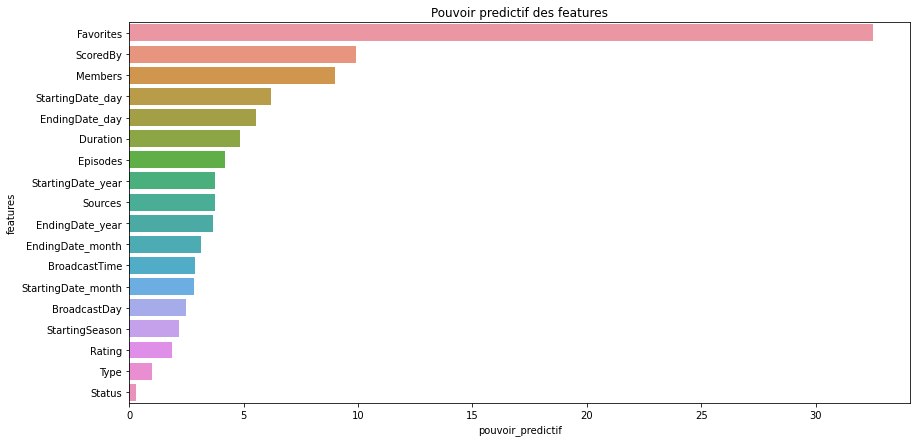

In [44]:
# Une fois l'importance réalisé on vas la plot afin mieux observer à quel point une feature peut faire varier notre accuracy
# Je crée un nouveau dataframe pour pouvoir stocker seulement les colonnes qui m'intéresse

plt.figure(figsize=(14,7))

d = pd.DataFrame()
d['features'] = X_train.columns
d['pouvoir_predictif'] = importance
print('Somme des pouvoirs predictif : {}'.format(d['pouvoir_predictif'].sum()))
d['pouvoir_predictif'] = d['pouvoir_predictif'].apply(lambda v : v*100)
d = d.sort_values(by='pouvoir_predictif', ascending=False)
sns.barplot(d['pouvoir_predictif'], d['features']).set_title('Pouvoir predictif des features');
print('L\'unité du pouvoir prédictif est en %')

In [ ]:
d.sort_values(by="pouvoir_predictif", ascending=False)

,features,pouvoir_predictif
10,Favorites,18.253951
9,Members,12.494105
8,ScoredBy,12.296904
13,StartingDate_day,6.302791
16,EndingDate_day,6.258808
14,EndingDate_year,5.307121
11,StartingDate_year,5.269942
6,Duration,5.240518
1,Episodes,4.719118
5,Sources,4.371423


# **Matrice de Confusion**

In [45]:
classes = Y.astype('category').cat.categories.tolist()
print(classes)

[7, 8, 9]


In [46]:
def show_cm(cm, labels):
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

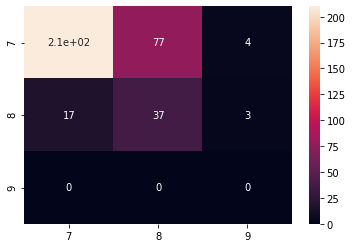

In [47]:
cm_train = confusion_matrix(y_pred, y_test, labels=classes)
show_cm(cm_train, classes)

# **Courbe Roc / Auc**

In [66]:
param_grid = {
              'n_neighbors':[1, 3, 5, 9, 21]
             }

model = KNN()
model, Y_pred = pipeline_details1(X_train, X_test, y_train, y_test, model,param_grid)

show_roc(model, X_test, Y_test)
print(model.best_score_)
print(model.best_params_)

TypeError: ignored

# **SVC + Validation curves**

ValueError: ignored

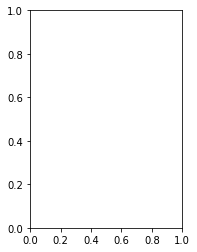

In [67]:
train_sizes = [1, 100, 500, 2000, 5000, 7654]
for model, i in [(RF(), 1), (KNN(),2)]:
    plt.subplot(1,2,i)
    learning_curves(model, df_dataAnime, X, Y, train_sizes, 5)

In [ ]:
train_scores, valid_scores = validation_curve(Ridge(), X, Y, "alpha",
                                               np.logspace(-7, 3, 3),
                                               cv=5)

train_scores.shape

(3, 5)

In [ ]:
valid_scores.shape

(3, 5)

In [ ]:
param_range = np.logspace(-6, -1, 3)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

print(train_scores_mean.shape)
print(train_scores_std.shape)

print(valid_scores_mean.shape)
print(valid_scores_std.shape)

(3,)
(3,)
(3,)
(3,)


In [ ]:
X.shape

(1391, 18)

In [ ]:
Y.shape

(1391,)

In [1]:
plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 4)
lw = 5
plt.semilogx(param_range, valid_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

NameError: ignored

# **Creer un profiling via colab**
https://medium.com/python-in-plain-english/how-to-use-pandas-profiling-on-google-colab-e34f34ff1c9f

In [ ]:
profile = ProfileReport(df_dataAnime, title="Rapport sur le dataset \"Anime \" ", html={'style' : {'full_width': True}})
profileRaw = ProfileReport(dataAnime, title="Rapport sur le dataset non transformé \"Anime \" ", html={'style' : {'full_width': True}})

In [ ]:
#profile.to_notebook_iframe()
profileRaw.to_notebook_iframe()

In [ ]:
#profile.to_file(output_file="Data_anime.html")
profileRaw.to_file(output_file="Data_animeRaw.html")